In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import matplotlib.pyplot as plt

In [2]:
from sklearn import neighbors

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
# EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'

In [5]:
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)


In [6]:
# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result


#### plot the normalised intensity to compare the 1to1 and 1to3

In [7]:
EXTRACTED_FEATURES_CSV = '{}/extracted-features/extracted-features.csv'.format(EXPERIMENT_DIR)
df = pd.read_csv(EXTRACTED_FEATURES_CSV)

In [8]:
df['intensity_log'] = np.log2(df.intensity)

In [9]:
# find the experiment-wide intensity median for each sequence
experiment_means_l = []
for group_name,group_df in df.groupby(['sequence','charge'], as_index=False):
    # intensity
    experiment_intensity_log_median = np.median(group_df.intensity_log)
    experiment_intensity_median = np.median(group_df.intensity)

    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    count = len(group_df)
    experiment_means_l.append((sequence,charge,experiment_intensity_median,experiment_intensity_log_median,count))

experiment_means_df = pd.DataFrame(experiment_means_l, columns=['sequence','charge','experiment_intensity_median','experiment_intensity_log_median','count'])


In [10]:
experiment_means_df.sample(5)

,sequence,charge,experiment_intensity_median,experiment_intensity_log_median,count
21654,Q[-17.0265]QEMMAALTDAIQDK,2,660.0,9.366322,13
20361,QFQDAGHFDAENIK,2,1849.0,10.851638,12
27890,VNEASGDGDGEDAVVILEK,2,1387.0,10.437752,17
19738,NSDVLQSPLDSAAR,2,2209.0,11.109178,19
17895,MEIYENENDQVEAVK,2,1515.0,10.539849,20


In [11]:
df = pd.merge(df, experiment_means_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [12]:
df['delta_intensity_log'] = df.intensity_log - df.experiment_intensity_log_median

In [13]:
df.columns

Index(['batch', 'charge', 'delta_mz_ppm', 'delta_rt', 'delta_scan', 'file_idx',
       'human', 'inferred', 'intensity', 'isotope_idx_not_in_saturation',
       'monoisotopic_mass', 'monoisotopic_mz_centroid', 'number_of_isotopes',
       'number_of_runs_extracted', 'peak_proportion_intensity', 'q_value',
       'rt_apex', 'run_name', 'scan_apex', 'sequence', 'theoretical_mz',
       'intensity_log', 'experiment_intensity_median',
       'experiment_intensity_log_median', 'count', 'delta_intensity_log'],
      dtype='object')

In [14]:
df[(df.sequence == 'CSDSTLLSNLLEEMK') & (df.charge == 2)][['intensity_log','experiment_intensity_log_median','delta_intensity_log']]

,intensity_log,experiment_intensity_log_median,delta_intensity_log
68134,10.769011,10.278449,0.490562
90952,10.216746,10.278449,-0.061704
136060,10.521600,10.278449,0.243151
159785,10.342075,10.278449,0.063625
183442,9.997179,10.278449,-0.281270
228461,10.051209,10.278449,-0.227241
274226,8.836050,10.278449,-1.442399
296763,10.738092,10.278449,0.459643
319732,10.233620,10.278449,-0.044830
341887,10.225207,10.278449,-0.053242


In [15]:
NUMBER_OF_RUNS = df.number_of_runs_extracted.max()
NUMBER_OF_RUNS

20

In [16]:
MINIMUM_NUMBER_OF_RUNS = int(NUMBER_OF_RUNS / 2)
NUMBER_OF_1TO1_RUNS = 10
NUMBER_OF_1TO3_RUNS = 10

#### before normalisation

In [17]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= int(NUMBER_OF_1TO1_RUNS / 2)) and (len(sequence_in_1to3_df) >= int(NUMBER_OF_1TO3_RUNS / 2)):
        average_intensity_in_1to1 = sequence_in_1to1_df.intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.intensity.mean()
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1, average_intensity_in_1to3, human))

In [18]:
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [19]:
sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 / sequence_occurences_in_batch_df.intensity_1to1

In [20]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

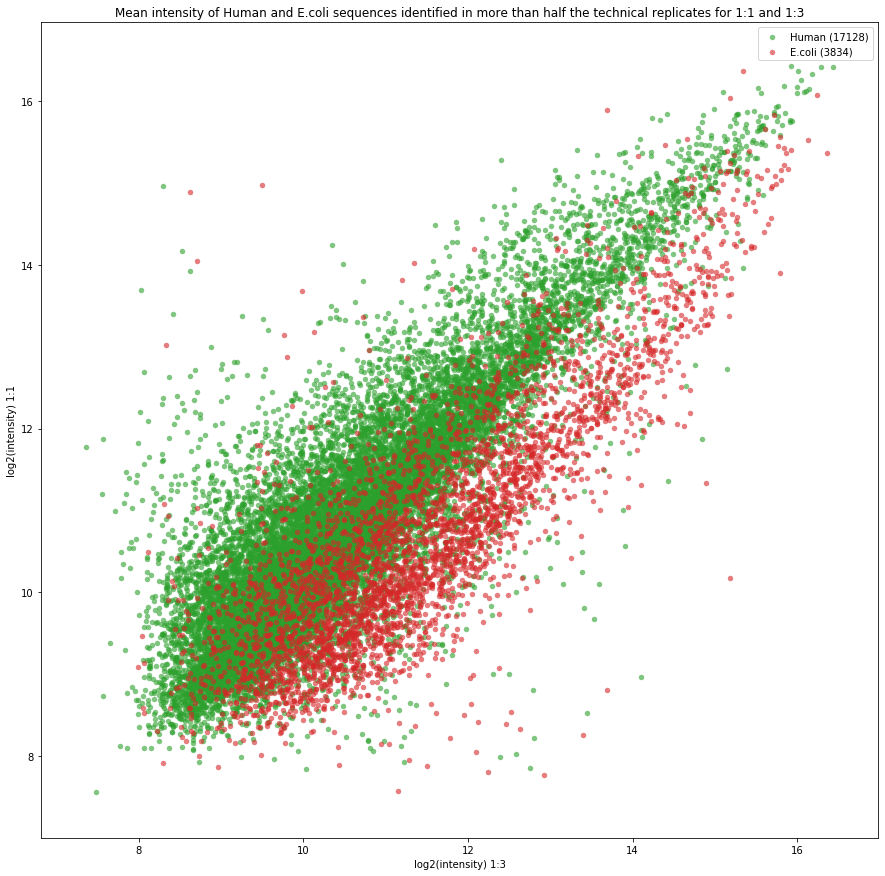

In [21]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

ax.scatter(np.log2(human_df.intensity_1to3), np.log2(human_df.intensity_1to1), marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_1to3), np.log2(ecoli_df.intensity_1to1), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

# plt.xlim((4,17))
# plt.ylim((4,17))

plt.show()

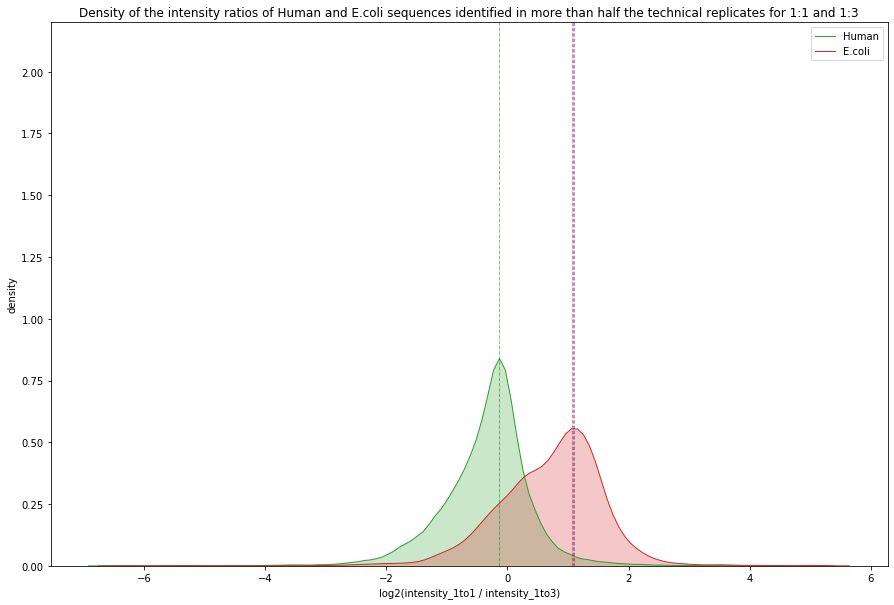

In [22]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

plt.axvline(np.log(3), color='darkblue', lw=2, ls=':', dash_capstyle='round', alpha=0.4)

plt.ylim((0,2.2))

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')

#### normalise intensity

In [23]:
training_attributes = ['monoisotopic_mz_centroid','rt_apex','scan_apex']

In [24]:
number_of_neighbours = 10
proportion_of_training_set_to_use = 0.4

run_df_l = []
for file_idx in df.file_idx.unique():
    # get the training set for this run
    sequences_selected_run_df = df[df.file_idx == file_idx].copy()
    training_set_selected_run_df = sequences_selected_run_df[(sequences_selected_run_df.human == True) & (sequences_selected_run_df.number_of_runs_extracted >= MINIMUM_NUMBER_OF_RUNS)]
    sample_size = int(proportion_of_training_set_to_use * len(training_set_selected_run_df))
    training_set_selected_run_df = training_set_selected_run_df.sample(n=sample_size)

    X_train = training_set_selected_run_df[training_attributes].values
    y_train = training_set_selected_run_df[['delta_intensity_log']].values[:,0]

    # fit the model
    knn = neighbors.KNeighborsRegressor(n_neighbors=number_of_neighbours, algorithm='kd_tree', weights='distance')
    _ = knn.fit(X_train, y_train)

    X = sequences_selected_run_df[training_attributes].values

    # estimate the delta intensity
    sequences_selected_run_df['predicted_delta_intensity_log'] = knn.predict(X)
    sequences_selected_run_df['normalised_intensity_log'] = sequences_selected_run_df.intensity_log - sequences_selected_run_df.predicted_delta_intensity_log
    sequences_selected_run_df['normalised_intensity'] = np.power(2, sequences_selected_run_df.normalised_intensity_log)
    run_df_l.append(sequences_selected_run_df)

normalised_experiment_df = pd.concat(run_df_l, axis=0, sort=False)


In [25]:
normalised_experiment_df[['sequence','charge','intensity','experiment_intensity_median','delta_intensity_log','predicted_delta_intensity_log','normalised_intensity']].sample(5)


,sequence,charge,intensity,experiment_intensity_median,delta_intensity_log,predicted_delta_intensity_log,normalised_intensity
436040,ENAEVDGDDDAEEM[15.9949]EAK,2,459,584.5,-0.348476,-0.348476,584.405681
411098,DITPLQVVLPNTALHLK,2,489,527.0,-0.107968,0.130865,446.595814
303438,HMGWTEAADLIVK,2,440,3834.0,-3.123275,-0.408973,584.205861
407238,WLPLEANPEVTNQFLK,2,7078,5659.0,0.326264,0.186243,6220.795117
156849,YFDEISQDTGK,2,4010,5355.0,-0.417284,0.358879,3126.878830


In [26]:
normalised_experiment_df[(normalised_experiment_df.sequence == 'CSDSTLLSNLLEEMK') & (normalised_experiment_df.charge == 2) & (normalised_experiment_df.batch == '1to1')][['intensity_log','experiment_intensity_log_median','delta_intensity_log','predicted_delta_intensity_log','normalised_intensity_log','normalised_intensity','run_name']]

,intensity_log,experiment_intensity_log_median,delta_intensity_log,predicted_delta_intensity_log,normalised_intensity_log,normalised_intensity,run_name
90952,10.216746,10.278449,-0.061704,-0.062415,10.279160,1242.612271,190719_Hela_Ecoli_1to1_04
136060,10.521600,10.278449,0.243151,-0.087195,10.608795,1561.584604,190719_Hela_Ecoli_1to1_03
159785,10.342075,10.278449,0.063625,-0.570884,10.912959,1928.093218,190719_Hela_Ecoli_1to1_06
183442,9.997179,10.278449,-0.281270,-0.448491,10.445670,1394.633464,190719_Hela_Ecoli_1to1_07
274226,8.836050,10.278449,-1.442399,-1.442399,10.278449,1242.000000,190719_Hela_Ecoli_1to1_09
319732,10.233620,10.278449,-0.044830,-0.254933,10.488553,1436.709470,190719_Hela_Ecoli_1to1_08
341887,10.225207,10.278449,-0.053242,-0.053242,10.278449,1242.000000,190719_Hela_Ecoli_1to1_05
387312,10.843921,10.278449,0.565472,0.042970,10.800951,1784.063480,190719_Hela_Ecoli_1to1_01
433131,10.540128,10.278449,0.261679,0.261679,10.278449,1242.000000,190719_Hela_Ecoli_1to1_02


In [24]:
normalised_experiment_df.to_csv('/Users/darylwilding-mcbride/Downloads/normalised_experiment.csv', index=False, header=True)

#### after normalisation

In [25]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in normalised_experiment_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= int(NUMBER_OF_1TO1_RUNS / 2)) and (len(sequence_in_1to3_df) >= int(NUMBER_OF_1TO3_RUNS / 2)):
        average_intensity_in_1to1 = sequence_in_1to1_df.normalised_intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.normalised_intensity.mean()
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1, average_intensity_in_1to3, human))

In [26]:
normalised_sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [27]:
normalised_sequence_occurences_in_batch_df['intensity_ratio'] = normalised_sequence_occurences_in_batch_df.intensity_1to3 / normalised_sequence_occurences_in_batch_df.intensity_1to1

In [28]:
normalised_human_df = normalised_sequence_occurences_in_batch_df[normalised_sequence_occurences_in_batch_df.human == True]
normalised_ecoli_df = normalised_sequence_occurences_in_batch_df[normalised_sequence_occurences_in_batch_df.human == False]

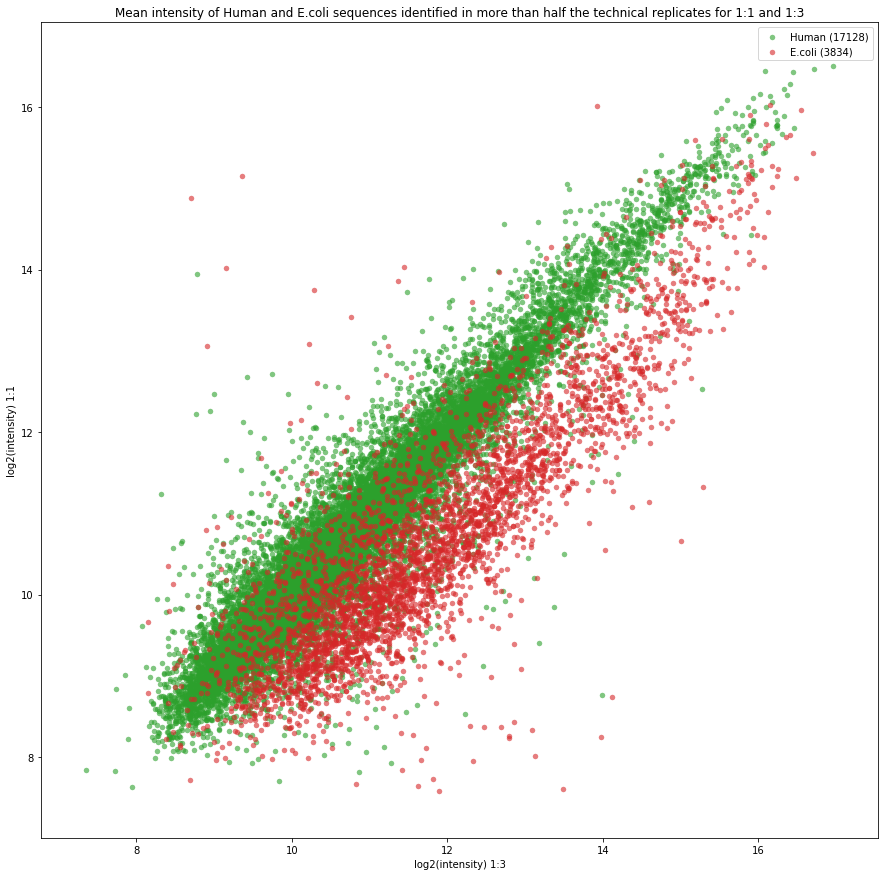

In [29]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

ax.scatter(np.log2(normalised_human_df.intensity_1to3), np.log2(normalised_human_df.intensity_1to1), marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(normalised_human_df)))
ax.scatter(np.log2(normalised_ecoli_df.intensity_1to3), np.log2(normalised_ecoli_df.intensity_1to1), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(normalised_ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

# plt.xlim((4,17))
# plt.ylim((4,17))

plt.show()

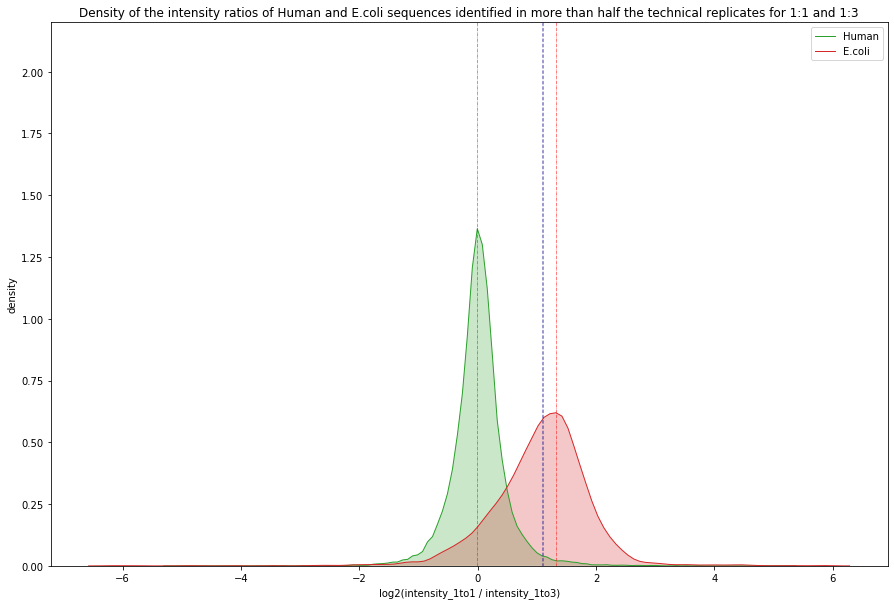

In [30]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(normalised_human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(normalised_ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

plt.axvline(np.log(3), color='darkblue', lw=2, ls=':', dash_capstyle='round', alpha=0.4)

plt.ylim((0,2.2))

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')

#### 1to1 CV before normalisation

In [31]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in normalised_experiment_df[normalised_experiment_df.batch == '1to1'].groupby(['sequence','charge']):
    if len(group_df) == 10:
        intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        sequence_cv_l.append((group_name[0], group_name[1], intensity_cv, np.median(group_df.intensity)))
sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','charge','intensity_cv','median_intensity'])


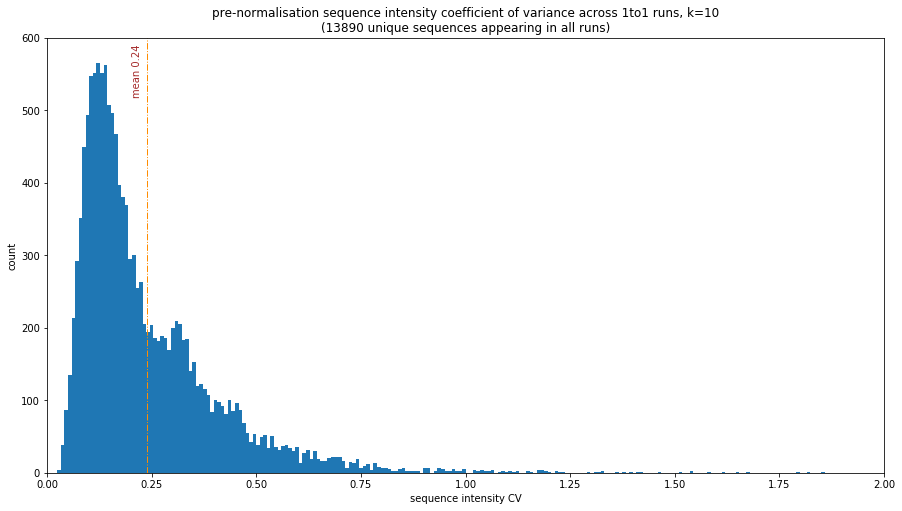

In [32]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('pre-normalisation sequence intensity coefficient of variance across 1to1 runs, k={}\n({} unique sequences appearing in all runs)'.format(number_of_neighbours, len(sequence_cv_df)))
plt.xlim((0,2))
plt.ylim((0,600))

plt.show()

#### 1to1 CV after normalisation

In [33]:
# for each sequence, find the CV
normalised_sequence_cv_l = []
for group_name,group_df in normalised_experiment_df[normalised_experiment_df.batch == '1to1'].groupby(['sequence','charge']):
    if len(group_df) == 10:
        intensity_cv = np.std(group_df.normalised_intensity) / np.mean(group_df.normalised_intensity)
        normalised_sequence_cv_l.append((group_name[0], group_name[1], intensity_cv, np.median(group_df.normalised_intensity)))
normalised_sequence_cv_df = pd.DataFrame(normalised_sequence_cv_l, columns=['sequence','charge','intensity_cv','median_intensity'])


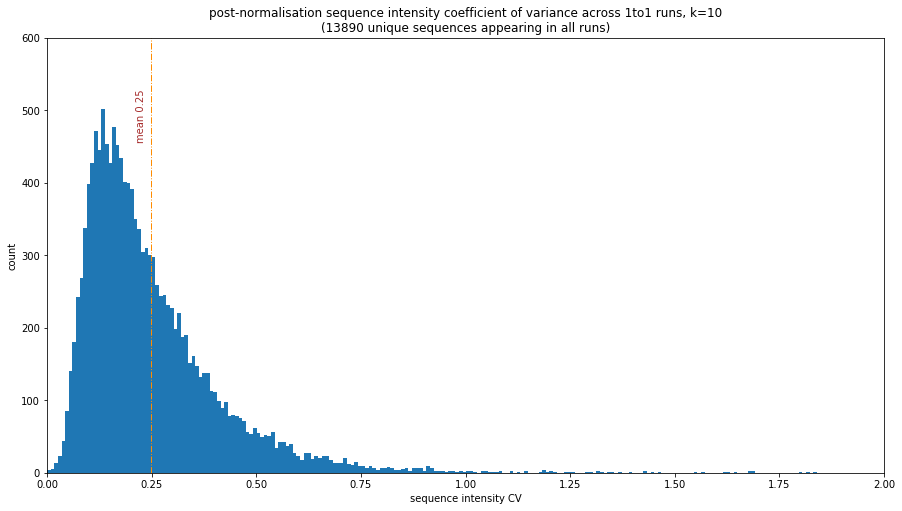

In [34]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = normalised_sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('post-normalisation sequence intensity coefficient of variance across 1to1 runs, k={}\n({} unique sequences appearing in all runs)'.format(number_of_neighbours, len(normalised_sequence_cv_df)))
plt.xlim((0,2))
plt.ylim((0,600))

plt.show()

#### look at the local adjustment in each dimension for a selected file

In [35]:
run_name = '190719_Hela_Ecoli_1to1_01'
file_idx = file_idx_for_run(run_name)

In [36]:
selected_run_df = normalised_experiment_df[normalised_experiment_df.file_idx == file_idx].copy()

##### intensity delta in the RT dimension

In [37]:
mean_delta_l = []
for group_name,group_df in selected_run_df.groupby(['rt_apex'], as_index=False):
    mean_delta_l.append((group_name, np.mean(group_df.predicted_delta_intensity_log)))
mean_delta_df = pd.DataFrame(mean_delta_l, columns=['rt_apex','mean_predicted_delta_intensity_log'])

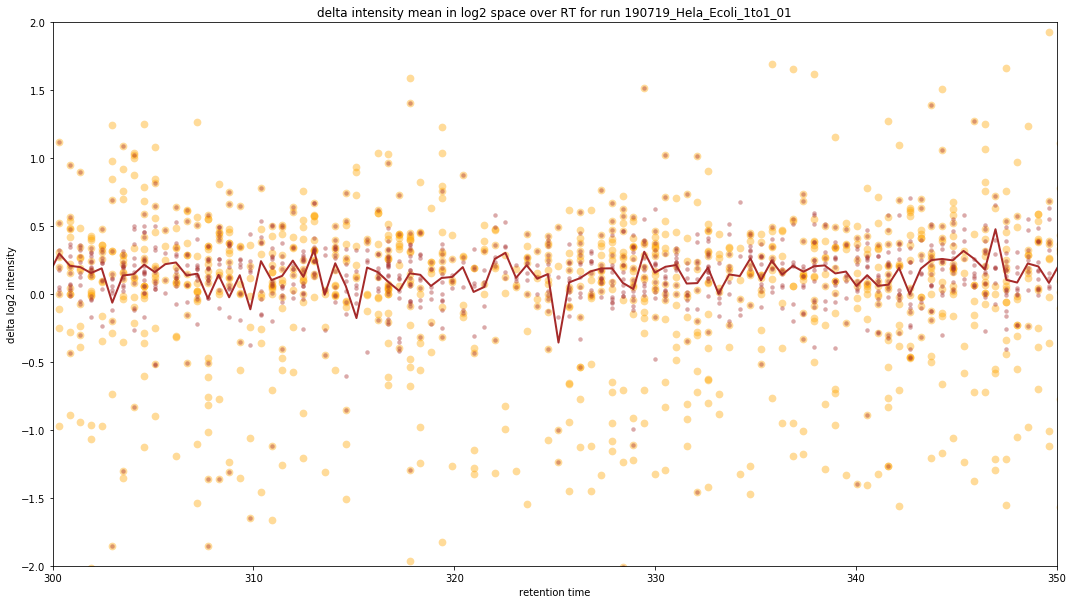

In [38]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(selected_run_df.rt_apex, selected_run_df.delta_intensity_log, marker='o', color='orange', lw=0, s=60, alpha=0.4)
ax.scatter(selected_run_df.rt_apex, selected_run_df.predicted_delta_intensity_log, marker='o', color='brown', lw=0, s=20, alpha=0.4)
ax.plot(mean_delta_df.rt_apex, mean_delta_df.mean_predicted_delta_intensity_log, marker='', color='brown', linestyle='-', linewidth=2, ms=5)

# plt.legend(loc='best')
plt.ylabel('delta log2 intensity')
plt.xlabel('retention time')
plt.title('delta intensity mean in log2 space over RT for run {}'.format(run_name))
plt.xlim((300,350))
plt.ylim((-2,2))

plt.show()

##### intensity delta in the CCS dimension

In [39]:
mean_delta_l = []
for group_name,group_df in selected_run_df.groupby(['scan_apex'], as_index=False):
    mean_delta_l.append((group_name, np.mean(group_df.predicted_delta_intensity_log)))
mean_delta_df = pd.DataFrame(mean_delta_l, columns=['scan_apex','mean_predicted_delta_intensity_log'])

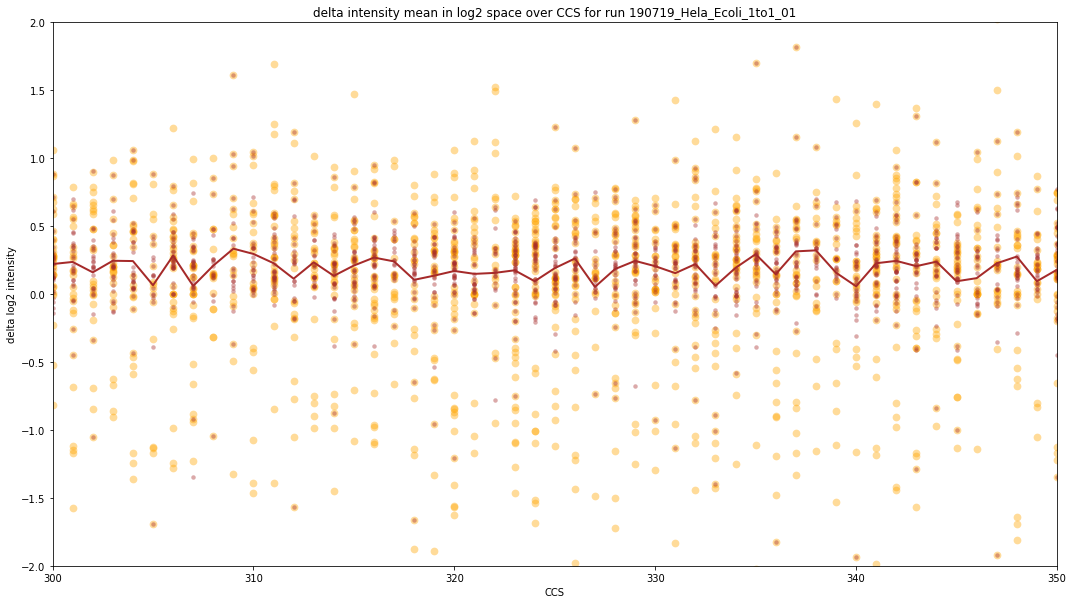

In [40]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(selected_run_df.scan_apex, selected_run_df.delta_intensity_log, marker='o', color='orange', lw=0, s=60, alpha=0.4)
ax.scatter(selected_run_df.scan_apex, selected_run_df.predicted_delta_intensity_log, marker='o', color='brown', lw=0, s=20, alpha=0.4)
ax.plot(mean_delta_df.scan_apex, mean_delta_df.mean_predicted_delta_intensity_log, marker='', color='brown', linestyle='-', linewidth=2, ms=5)

# plt.legend(loc='best')
plt.ylabel('delta log2 intensity')
plt.xlabel('CCS')
plt.title('delta intensity mean in log2 space over CCS for run {}'.format(run_name))
plt.xlim((300,350))
plt.ylim((-2,2))

plt.show()

##### intensity delta in the m/z dimension

In [41]:
mean_delta_l = []
selected_run_df['mz_truncated'] = selected_run_df.monoisotopic_mz_centroid.astype(int)
for group_name,group_df in selected_run_df.groupby(['mz_truncated'], as_index=False):
    mean_delta_l.append((group_name, np.mean(group_df.predicted_delta_intensity_log)))
mean_delta_df = pd.DataFrame(mean_delta_l, columns=['monoisotopic_mz_centroid','mean_predicted_delta_intensity_log'])

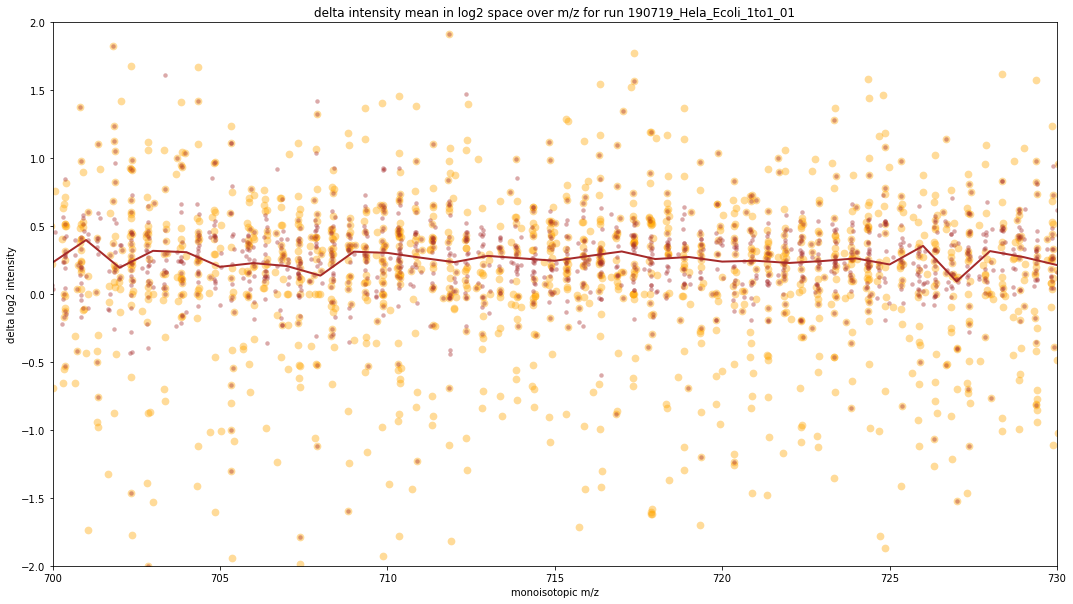

In [42]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(selected_run_df.monoisotopic_mz_centroid, selected_run_df.delta_intensity_log, marker='o', color='orange', lw=0, s=60, alpha=0.4)
ax.scatter(selected_run_df.monoisotopic_mz_centroid, selected_run_df.predicted_delta_intensity_log, marker='o', color='brown', lw=0, s=20, alpha=0.4)
ax.plot(mean_delta_df.monoisotopic_mz_centroid, mean_delta_df.mean_predicted_delta_intensity_log, marker='', color='brown', linestyle='-', linewidth=2, ms=5)

# plt.legend(loc='best')
plt.ylabel('delta log2 intensity')
plt.xlabel('monoisotopic m/z')
plt.title('delta intensity mean in log2 space over m/z for run {}'.format(run_name))
plt.xlim((700,730))
plt.ylim((-2,2))

plt.show()

#### sequence CV by intensity

##### before normalisation

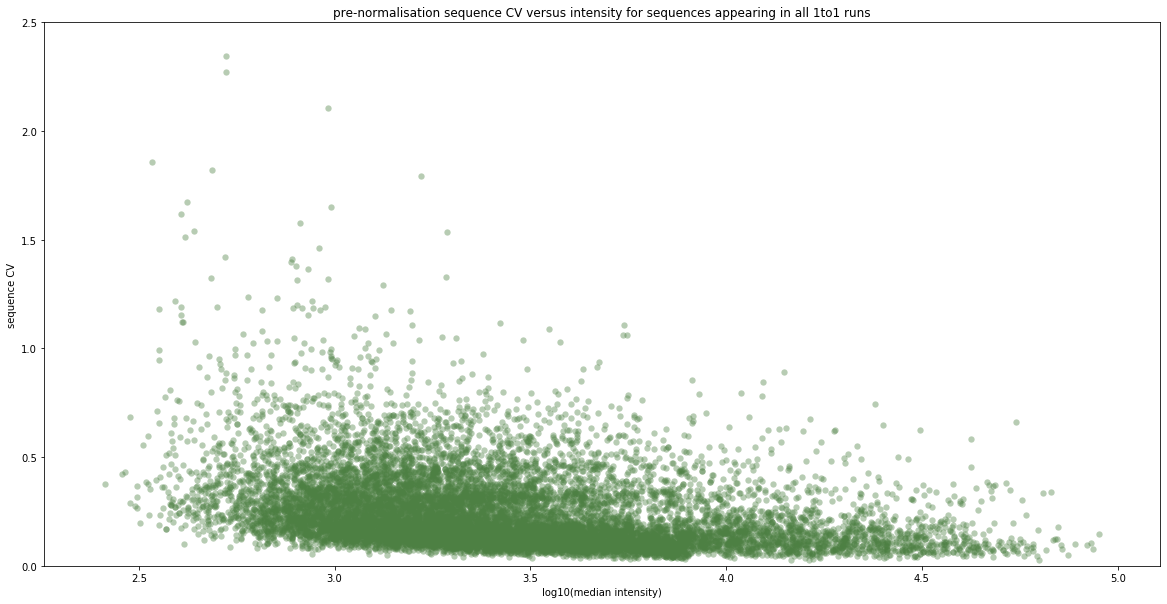

In [43]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(20)
plt.margins(0.06)

title = 'pre-normalisation sequence CV versus intensity for sequences appearing in all 1to1 runs'
plt.title(title)

ax.scatter(np.log10(sequence_cv_df.median_intensity), sequence_cv_df.intensity_cv, marker='o', color='#4D8043', lw=0, s=40, alpha=0.4)

plt.xlabel('log10(median intensity)')
plt.ylabel('sequence CV')

# plt.xlim((4,17))
plt.ylim((0,2.5))

plt.show()

In [44]:
len(sequence_cv_df)

13890

##### after normalisation

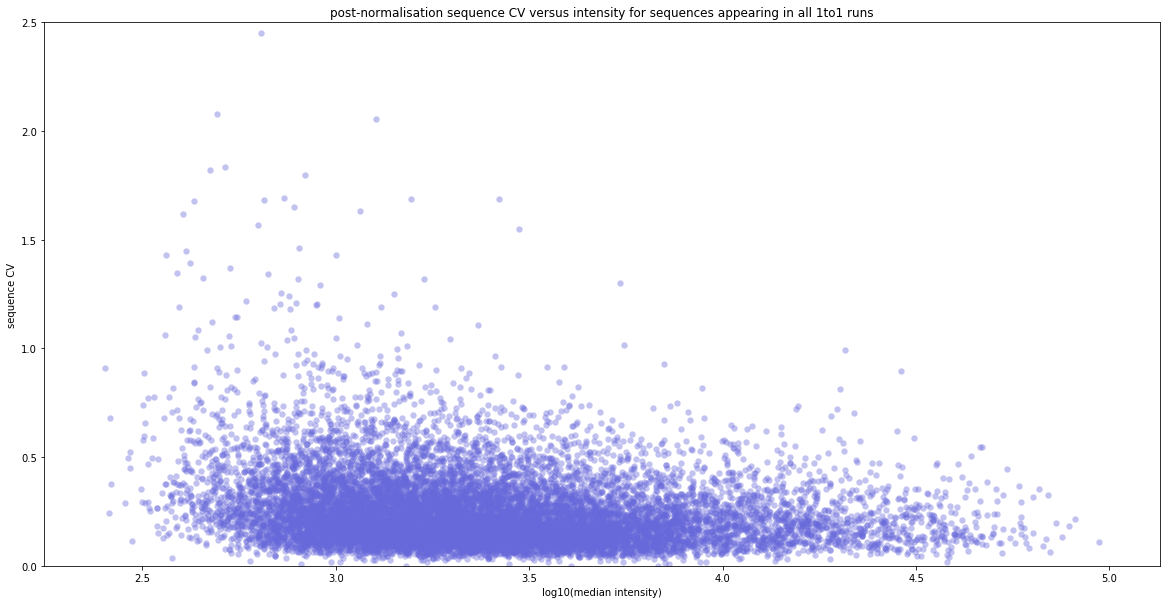

In [45]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(20)
plt.margins(0.06)

title = 'post-normalisation sequence CV versus intensity for sequences appearing in all 1to1 runs'
plt.title(title)

ax.scatter(np.log10(normalised_sequence_cv_df.median_intensity), normalised_sequence_cv_df.intensity_cv, marker='o', color='#6768DA', lw=0, s=40, alpha=0.4)

plt.xlabel('log10(median intensity)')
plt.ylabel('sequence CV')

# plt.xlim((4,17))
plt.ylim((0,2.5))

plt.show()

In [46]:
len(normalised_sequence_cv_df)

13890

#### Relative log expression (RLE) plot

In [47]:
normalised_experiment_df.columns

Index(['batch', 'charge', 'delta_mz_ppm', 'delta_rt', 'delta_scan', 'file_idx',
       'human', 'inferred', 'intensity', 'isotope_idx_not_in_saturation',
       'monoisotopic_mass', 'monoisotopic_mz_centroid', 'number_of_isotopes',
       'number_of_runs_extracted', 'peak_proportion_intensity', 'q_value',
       'rt_apex', 'run_name', 'scan_apex', 'sequence', 'theoretical_mz',
       'intensity_log', 'experiment_intensity_mean',
       'experiment_intensity_log_mean', 'experiment_intensity_median',
       'experiment_intensity_log_median', 'delta_intensity_log',
       'predicted_delta_intensity_log', 'normalised_intensity_log',
       'normalised_intensity'],
      dtype='object')

In [48]:
rle_df = normalised_experiment_df[normalised_experiment_df.human == True][['sequence','charge','run_name','normalised_intensity','normalised_intensity_log','batch']]

In [49]:
rle_df['intensity_log'] = np.log10(rle_df.normalised_intensity)

In [50]:
# find the experiment-wide intensity median for each sequence in log space
l = []
for group_name,group_df in rle_df.groupby(['sequence','charge'], as_index=False):
    # intensity
    log_median = np.median(group_df.intensity_log)
    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    count = len(group_df)
    l.append((sequence,charge,log_median,count))

experiment_median_df = pd.DataFrame(l, columns=['sequence','charge','log_median','count'])


In [51]:
rle_df = pd.merge(rle_df, experiment_median_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [52]:
rle_df['deviation_from_median'] = rle_df.intensity_log - rle_df.log_median

In [53]:
rle_df.sample(n=20)

,sequence,charge,run_name,normalised_intensity,normalised_intensity_log,batch,intensity_log,log_median,count,deviation_from_median
308302,VHPVSTMIK,2,190719_Hela_Ecoli_1to3_04,1758.000000,10.779719,1to3,3.245019,3.245019,19,0.000000
173087,IVNTESFVMPWQAVQDVK,2,190719_Hela_Ecoli_1to3_09,2088.542377,11.028281,1to3,3.319843,3.118544,20,0.201299
177166,QTWDQLLLHYQQEAK,2,190719_Hela_Ecoli_1to3_09,444.055093,8.794595,1to3,2.647437,2.570617,19,0.076820
353450,GGFVLAGPGDADGASSR,2,190719_Hela_Ecoli_1to1_02,601.000000,9.231221,1to1,2.778874,2.778874,17,0.000000
364879,VDIEGPDVNIEGPEGK,2,190719_Hela_Ecoli_1to1_02,3684.642417,11.847309,1to1,3.566395,3.510738,20,0.055657
267911,Q[-17.0265]QTVGGVNYFFDVEVGR,2,190719_Hela_Ecoli_1to1_08,1442.354325,10.494210,1to1,3.159072,3.159072,20,0.000000
291101,VIMGEEVEPVGLMTGSGVVGVK,2,190719_Hela_Ecoli_1to1_05,1339.000000,10.386940,1to1,3.126781,3.126781,19,0.000000
361224,QYPISLVLAPTR,2,190719_Hela_Ecoli_1to1_02,2623.594843,11.357329,1to1,3.418897,3.611298,15,-0.192402
216854,VQQLLHICSEHFDSK,2,190719_Hela_Ecoli_1to3_06,733.982970,9.519603,1to3,2.865686,2.865686,18,0.000000
61592,LLAETHYQLGLAYGYNSQYDEAVAQFSK,3,190719_Hela_Ecoli_1to3_05,513.497301,9.004213,1to3,2.710538,2.621176,13,0.089362


In [54]:
rle_df.deviation_from_median.min()

-2.4406835183635187

In [55]:
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

                        label  lower_quartile  lower_whisker  median  \
0   190719_Hela_Ecoli_1to1_01       -0.020137      -0.115645     0.0   
1   190719_Hela_Ecoli_1to1_02       -0.024659      -0.119544     0.0   
2   190719_Hela_Ecoli_1to1_03       -0.023004      -0.113949     0.0   
3   190719_Hela_Ecoli_1to1_04       -0.022384      -0.114899     0.0   
4   190719_Hela_Ecoli_1to1_05       -0.021267      -0.114529     0.0   
5   190719_Hela_Ecoli_1to1_06       -0.023972      -0.114753     0.0   
6   190719_Hela_Ecoli_1to1_07       -0.024347      -0.121072     0.0   
7   190719_Hela_Ecoli_1to1_08       -0.020807      -0.114264     0.0   
8   190719_Hela_Ecoli_1to1_09       -0.026772      -0.127095     0.0   
9   190719_Hela_Ecoli_1to1_10       -0.024524      -0.120965     0.0   
10  190719_Hela_Ecoli_1to3_01       -0.020620      -0.123430     0.0   
11  190719_Hela_Ecoli_1to3_02       -0.023217      -0.125747     0.0   
12  190719_Hela_Ecoli_1to3_03       -0.015855      -0.124848    

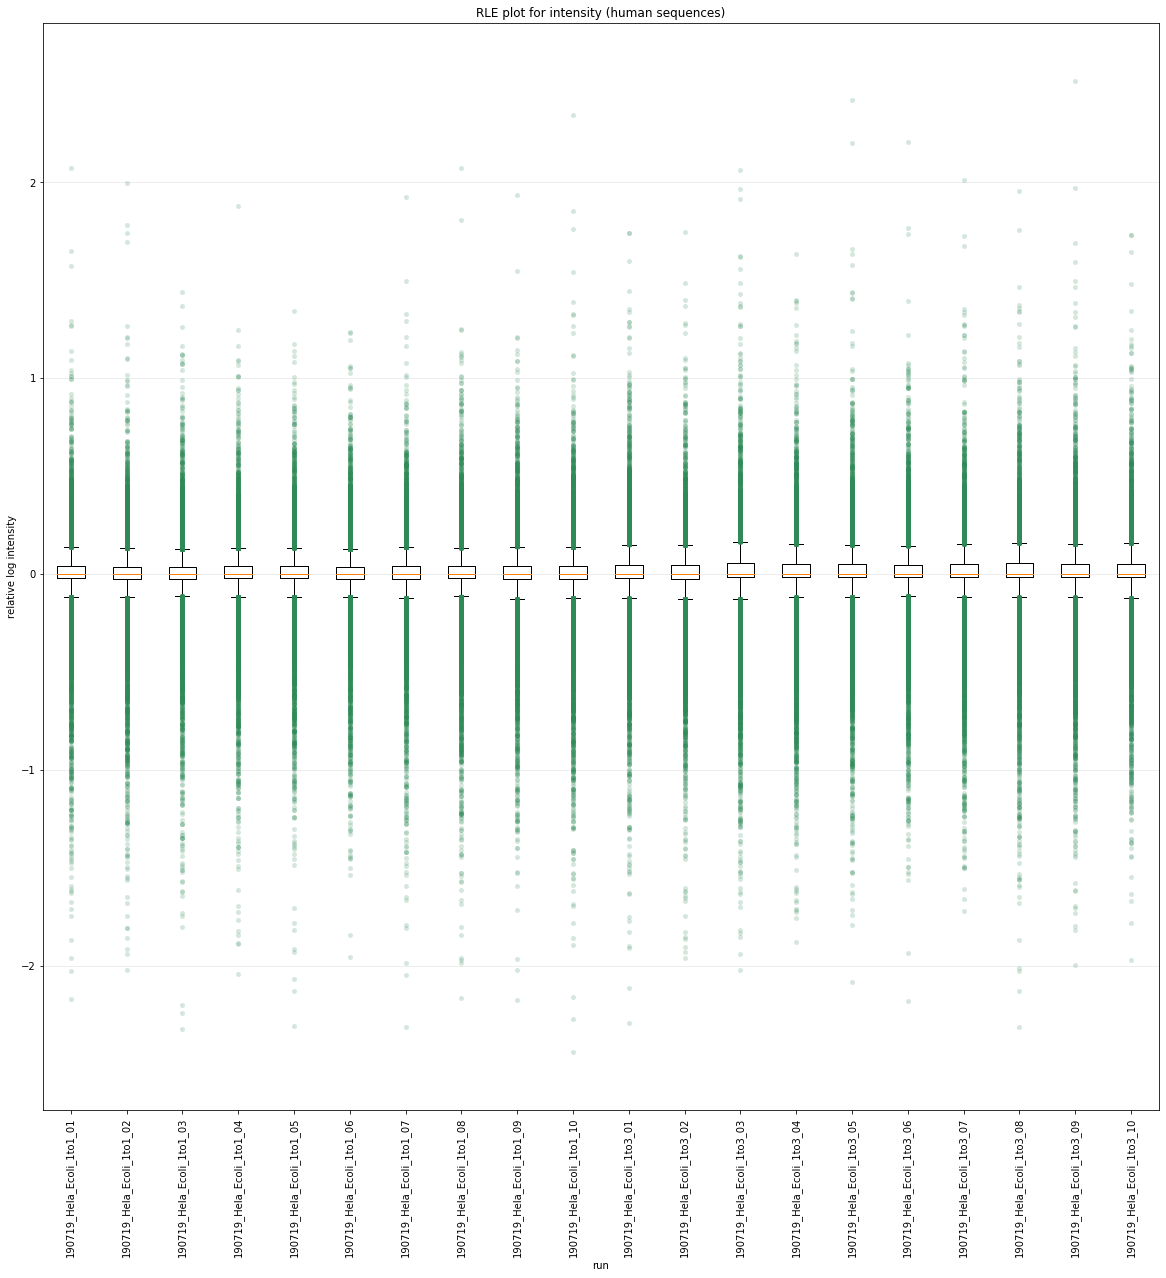

In [56]:
f, ax = plt.subplots()
f.set_figheight(20)
f.set_figwidth(20)
plt.margins(0.06)

title = 'RLE plot for intensity (human sequences)'
plt.title(title)

l = []
names = []
for group_name,group_df in rle_df.groupby(['run_name'], as_index=False):
    names.append(group_name)
    l.append(group_df.deviation_from_median.values)

flierprops = dict(marker='.', markerfacecolor='seagreen', markersize=10, alpha=0.2, linestyle='none', markeredgecolor=None, markeredgewidth=0)
# bp = plt.boxplot(l, notch=0, sym='.', vert=1, whis=1.5, flierprops=flierprops, patch_artist=True, labels=names)
bp = plt.boxplot(l, notch=0, sym='.', vert=1, whis=1.5, flierprops=flierprops, labels=names)

# for box in bp['boxes']:
#     # change outline color
#     box.set( color='#7570b3', linewidth=2)
#     # change fill color
#     box.set( facecolor = '#1b9e77' )

# for whisker in bp['whiskers']:
#     whisker.set(color='#7570b3', linewidth=2)

# for cap in bp['caps']:
#     cap.set(color='#7570b3', linewidth=2)

# for median in bp['medians']:
#     median.set(color='#b2df8a', linewidth=2)
    
print(get_box_plot_data(names, bp))
    
# add a light horizontal grid
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

plt.xlabel('run')
plt.ylabel('relative log intensity')

# plt.xlim((4,17))
# plt.ylim((-0.05,0.05))

# ax.set_xticklabels(names)
plt.xticks(rotation=90)

plt.show()

